# MBTI Prediction - Strategy 2
**Objective:** In this notebook, we will train a classification model for each letter's group (I/E, S/N, T/F, J/P) and not only one to directly predict the full MBTI type.

## Libraries

In [38]:
from itertools import islice 
from joblib import dump, load
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

## Data import

In [8]:
df = pd.read_csv('../mbti_data.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [9]:
df.shape

(8675, 2)

## Data preprocessing

Split each line (~50 posts) into subline (10 posts).

In [10]:
def dataframe_split(df, n=10):
    df_r = pd.DataFrame(columns=['type','posts'])
    for i in range(len(df)):
        full_list = df.loc[i, 'posts'].split('|||')
        sub_list = [full_list[i:i+n] for i in range(0, len(full_list),n)]
        for j in sub_list:
            df_r = df_r.append({'type': df.loc[i, 'type'], 'posts': ' '.join(j)}, ignore_index=True)
    return df_r

In [11]:
%%time
df = dataframe_split(df)

Wall time: 1min 37s


In [12]:
df.shape

(42734, 2)

We prepare our targets. 
<br>We will have one classifier to predict the "target_ie" value, one for "target_sn", one for "target_tf" and one for "target_jp".

In [13]:
df['target_ie'] = df['type'].apply(lambda row: row[0])
df['target_sn'] = df['type'].apply(lambda row: row[1])
df['target_tf'] = df['type'].apply(lambda row: row[2])
df['target_jp'] = df['type'].apply(lambda row: row[3])
df.head()

,type,posts,target_ie,target_sn,target_tf,target_jp
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,I,N,F,J
1,INFJ,http://playeressence.com/wp-content/uploads/20...,I,N,F,J
2,INFJ,Yo entp ladies... if you're into a complimenta...,I,N,F,J
3,INFJ,Banned for watching movies in the corner with ...,I,N,F,J
4,INFJ,http://www.serebii.net/potw-dp/Scizor.jpg Not ...,I,N,F,J


Let's see the distribition of the new variables created.

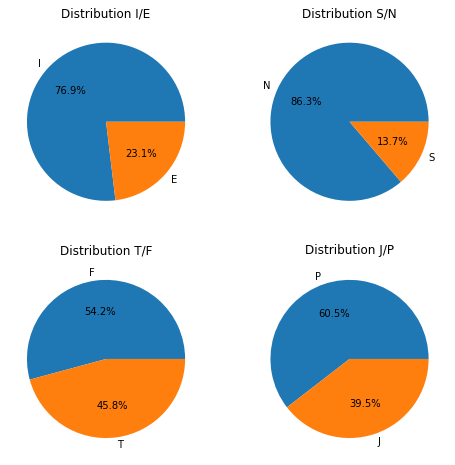

In [14]:
ie_dist = df['target_ie'].value_counts().rename_axis('types').reset_index(name='counts')
sn_dist = df['target_sn'].value_counts().rename_axis('types').reset_index(name='counts')
tf_dist = df['target_tf'].value_counts().rename_axis('types').reset_index(name='counts')
jp_dist = df['target_jp'].value_counts().rename_axis('types').reset_index(name='counts')

fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs[0, 0].pie(ie_dist['counts'], labels=ie_dist['types'], autopct='%1.1f%%')
axs[0, 0].set_title('Distribution I/E')
axs[0, 1].pie(sn_dist['counts'], labels=sn_dist['types'], autopct='%1.1f%%')
axs[0, 1].set_title('Distribution S/N')
axs[1, 0].pie(tf_dist['counts'], labels=tf_dist['types'], autopct='%1.1f%%')
axs[1, 0].set_title('Distribution T/F')
axs[1, 1].pie(jp_dist['counts'], labels=jp_dist['types'], autopct='%1.1f%%')
axs[1, 1].set_title('Distribution J/P')
plt.show()

From an overall point of view, we notice that the classes are unbalanced. We will therefore use the "F1 score" metric to measure the performance of our models.

Let's preprocess the posts.

In [15]:
stop_words = set(stopwords.words('english'))
porter_stemmer = PorterStemmer()

def preprocessing(text, stemming_on=False, stop_words=stop_words, porter_stemmer=porter_stemmer):
    text = text.lower()                                          # Lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)                  # Noise removal (regex to remove punctuations)
    text = text.strip()                                          # Noise removal (extra spaces)
    words = text.split()                                         # Split sentence into list of words
    words = [w for w in words if not w in stop_words]            # Stopwords removal
    if(stemming_on):
        words = [porter_stemmer.stem(word) for word in words]    # Replace the word by its stem
    text = ' '.join(words)                                       # Transform list of words to str
    return text

In [16]:
%%time
df['posts_preproc'] = df['posts'].apply(lambda row: preprocessing(row, stemming_on=True))

Wall time: 1min 48s


In [17]:
df.head()

,type,posts,target_ie,target_sn,target_tf,target_jp,posts_preproc
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,I,N,F,J,http www youtub com watch v qsxhcwe3krw http 4...
1,INFJ,http://playeressence.com/wp-content/uploads/20...,I,N,F,J,http playeress com wp content upload 2013 08 r...
2,INFJ,Yo entp ladies... if you're into a complimenta...,I,N,F,J,yo entp ladi complimentari person well hey mai...
3,INFJ,Banned for watching movies in the corner with ...,I,N,F,J,ban watch movi corner dunc ban health class cl...
4,INFJ,http://www.serebii.net/potw-dp/Scizor.jpg Not ...,I,N,F,J,http www serebii net potw dp scizor jpg artist...


## Analysis - Best configuration

**Vectorization**

In [18]:
c_vectorizer = CountVectorizer()
ti_vectorizer = TfidfVectorizer()

c_X = c_vectorizer.fit_transform(df['posts_preproc'])
ti_X = ti_vectorizer.fit_transform(df['posts_preproc'])

**Training**

In [63]:
config = {
    'data_vect': {
        'CountVectorizer': c_X,
        'TfidfVectorizer': ti_X
    },
    'classifier': {
        'LinearSVC': LinearSVC(class_weight='balanced', random_state=14, max_iter=50000), 
        'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=14, max_iter=50000)
    }
}

In [64]:
global_perf_trainings = {
    'target_ie': [],
    'target_sn': [],
    'target_tf': [],
    'target_jp': []
}

In [65]:
def training_analysis(df, config, target, random_state):
    perf_trainings = []
    for vectorizer in config['data_vect']:
        X_train, X_test, y_train, y_test = train_test_split(config['data_vect'][vectorizer], df[target], test_size=0.2, random_state=random_state)
        for classifier in config['classifier']:
            clf = config['classifier'][classifier]
            clf.fit(X_train, y_train)
            print(f'{vectorizer} | {classifier}:')
            print(f'_________________________\n')
            y_pred = config['classifier'][classifier].predict(X_test)
            perf_trainings.append(f1_score(y_test, y_pred, average='macro'))
            print(f'{classification_report(y_test, y_pred)}\n')
            print(f'--------------------------------------------------------------\n')
    global_perf_trainings[target] = perf_trainings

*Target I/E*

In [66]:
%%time
training_analysis(df, config, 'target_ie', 14)

CountVectorizer | LinearSVC:
_________________________

              precision    recall  f1-score   support

           E       0.40      0.46      0.43      1915
           I       0.84      0.80      0.82      6632

    accuracy                           0.72      8547
   macro avg       0.62      0.63      0.62      8547
weighted avg       0.74      0.72      0.73      8547


--------------------------------------------------------------

CountVectorizer | LogisticRegression:
_________________________

              precision    recall  f1-score   support

           E       0.44      0.52      0.48      1915
           I       0.85      0.81      0.83      6632

    accuracy                           0.74      8547
   macro avg       0.65      0.66      0.65      8547
weighted avg       0.76      0.74      0.75      8547


--------------------------------------------------------------

TfidfVectorizer | LinearSVC:
_________________________

              precision    recall  f1-s

*Target S/N*

In [67]:
%%time
training_analysis(df, config, 'target_sn', 14)

CountVectorizer | LinearSVC:
_________________________

              precision    recall  f1-score   support

           N       0.90      0.88      0.89      7395
           S       0.33      0.38      0.36      1152

    accuracy                           0.81      8547
   macro avg       0.62      0.63      0.62      8547
weighted avg       0.82      0.81      0.82      8547


--------------------------------------------------------------

CountVectorizer | LogisticRegression:
_________________________

              precision    recall  f1-score   support

           N       0.91      0.88      0.89      7395
           S       0.36      0.46      0.40      1152

    accuracy                           0.82      8547
   macro avg       0.64      0.67      0.65      8547
weighted avg       0.84      0.82      0.83      8547


--------------------------------------------------------------

TfidfVectorizer | LinearSVC:
_________________________

              precision    recall  f1-s

*Target T/F*

In [68]:
%%time
training_analysis(df, config, 'target_tf', 14)

CountVectorizer | LinearSVC:
_________________________

              precision    recall  f1-score   support

           F       0.71      0.71      0.71      4628
           T       0.66      0.66      0.66      3919

    accuracy                           0.69      8547
   macro avg       0.69      0.69      0.69      8547
weighted avg       0.69      0.69      0.69      8547


--------------------------------------------------------------

CountVectorizer | LogisticRegression:
_________________________

              precision    recall  f1-score   support

           F       0.75      0.74      0.74      4628
           T       0.70      0.70      0.70      3919

    accuracy                           0.72      8547
   macro avg       0.72      0.72      0.72      8547
weighted avg       0.72      0.72      0.72      8547


--------------------------------------------------------------

TfidfVectorizer | LinearSVC:
_________________________

              precision    recall  f1-s

*Target J/P*

In [69]:
%%time
training_analysis(df, config, 'target_jp', 14)

CountVectorizer | LinearSVC:
_________________________

              precision    recall  f1-score   support

           J       0.54      0.55      0.55      3380
           P       0.70      0.70      0.70      5167

    accuracy                           0.64      8547
   macro avg       0.62      0.62      0.62      8547
weighted avg       0.64      0.64      0.64      8547


--------------------------------------------------------------

CountVectorizer | LogisticRegression:
_________________________

              precision    recall  f1-score   support

           J       0.57      0.59      0.58      3380
           P       0.73      0.71      0.72      5167

    accuracy                           0.67      8547
   macro avg       0.65      0.65      0.65      8547
weighted avg       0.67      0.67      0.67      8547


--------------------------------------------------------------

TfidfVectorizer | LinearSVC:
_________________________

              precision    recall  f1-s

**Results visualisation**

In [86]:
config_str = ['LinearSVC', 'LogisticRegression', 'LinearSVC', 'LogisticRegression']
bar_color = ['tomato', 'tomato', 'dodgerblue', 'dodgerblue']
custom_legend = [Line2D([0], [0], color='tomato', lw=4), Line2D([0], [0], color='dodgerblue', lw=4)]

def bar_value(y):
    for index, value in enumerate(y):
        plt.text(value, index, str(value))

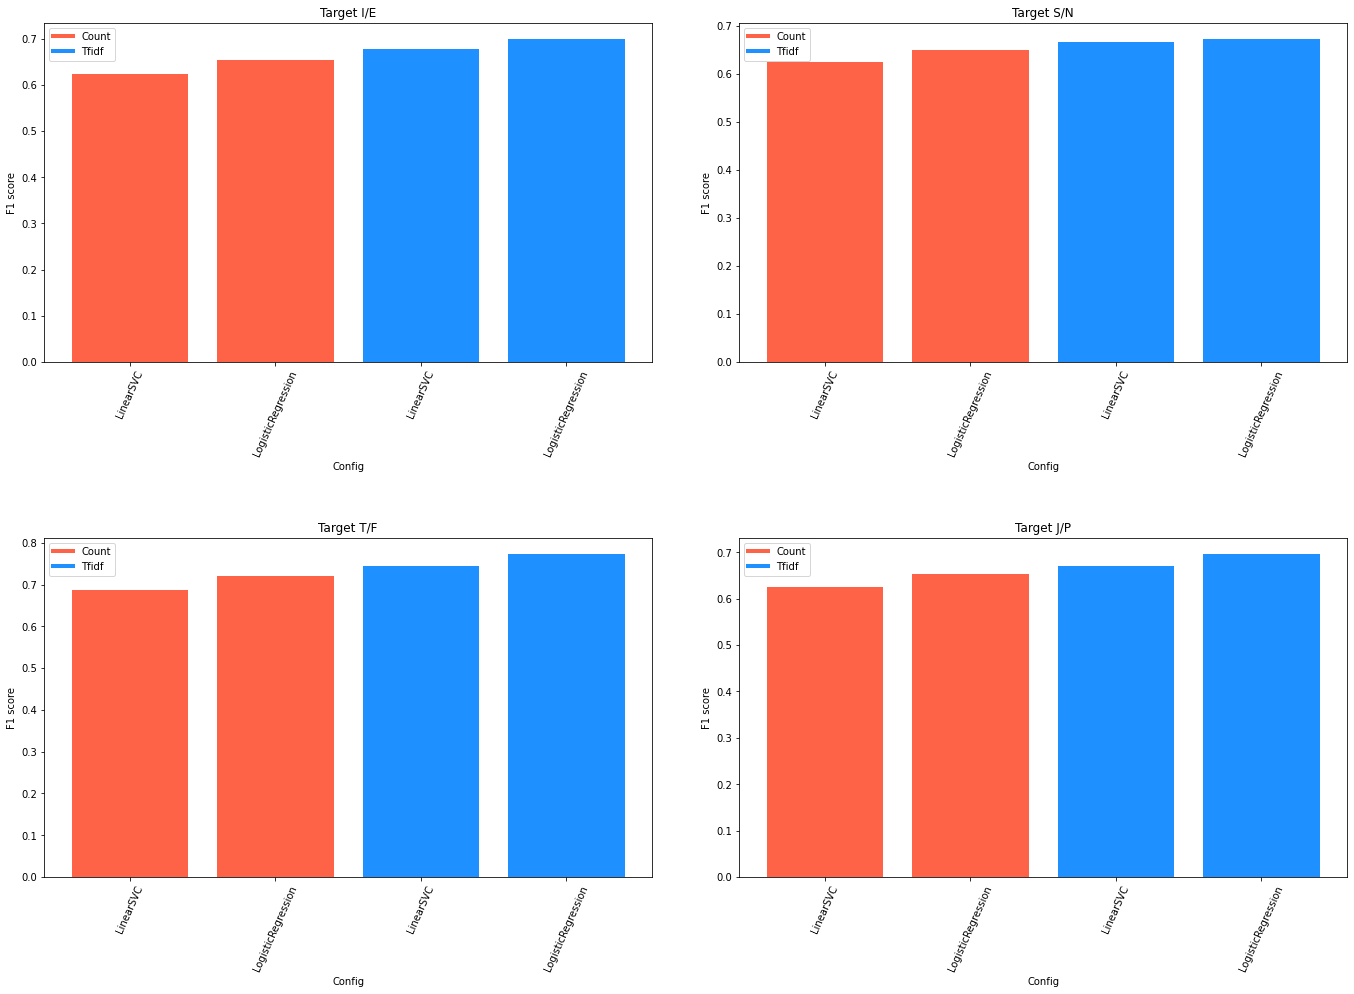

In [92]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))

axs[0, 0].bar(range(len(global_perf_trainings['target_ie'])), global_perf_trainings['target_ie'], color=bar_color)
axs[0, 0].set_xticks(range(len(config_str)))
axs[0, 0].set_xticklabels(config_str, rotation=66)
axs[0, 0].set_xlabel('Config')
axs[0, 0].set_ylabel('F1 score')
axs[0, 0].set_title('Target I/E')
axs[0, 0].legend(custom_legend, ['Count', 'Tfidf'])

axs[0, 1].bar(range(len(global_perf_trainings['target_sn'])), global_perf_trainings['target_sn'], color=bar_color)
axs[0, 1].set_xticks(range(len(config_str)))
axs[0, 1].set_xticklabels(config_str, rotation=66)
axs[0, 1].set_xlabel('Config')
axs[0, 1].set_ylabel('F1 score')
axs[0, 1].set_title('Target S/N')
axs[0, 1].legend(custom_legend, ['Count', 'Tfidf'])

axs[1, 0].bar(range(len(global_perf_trainings['target_tf'])), global_perf_trainings['target_tf'], color=bar_color)
axs[1, 0].set_xticks(range(len(config_str)))
axs[1, 0].set_xticklabels(config_str, rotation=66)
axs[1, 0].set_xlabel('Config')
axs[1, 0].set_ylabel('F1 score')
axs[1, 0].set_title('Target T/F')
axs[1, 0].legend(custom_legend, ['Count', 'Tfidf'])

axs[1, 1].bar(range(len(global_perf_trainings['target_jp'])), global_perf_trainings['target_jp'], color=bar_color)
axs[1, 1].set_xticks(range(len(config_str)))
axs[1, 1].set_xticklabels(config_str, rotation=66)
axs[1, 1].set_xlabel('Config')
axs[1, 1].set_ylabel('F1 score')
axs[1, 1].set_title('Target J/P')
axs[1, 1].legend(custom_legend, ['Count', 'Tfidf'])

fig.tight_layout(pad=5)

plt.show()

**Analysis conclusion**

We select the following configurations:

| Target | Vectorization |     Classifier     |
|:------:|:-------------:|:------------------:|
|   I/E  |     Tfidf     | LogisticRegression |
|   S/N  |     Tfidf     | LogisticRegression |
|   T/F  |     Tfidf     | LogisticRegression |
|   J/P  |     Tfidf     | LogisticRegression |

## Training

**Vectorization**

In [73]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit(df['posts_preproc'])
X = vectorizer.transform(df['posts_preproc'])

dump(tfidf, '../vectorizers/tfidf.joblib')      # We save the vectorizer

['../vectorizers/tfidf.joblib']

**Target I/E**

In [75]:
y = df['target_ie']

classifier = LogisticRegression(class_weight='balanced', random_state=14, max_iter=50000)
classifier.fit(X, y)

dump(classifier, '../models/model_ie.joblib')    # We save the model

['../models/model_ie.joblib']

 **Target S/N**

In [76]:
y = df['target_sn']

classifier = LogisticRegression(class_weight='balanced', random_state=14, max_iter=50000)
classifier.fit(X, y)

dump(classifier, '../models/model_sn.joblib')    # We save the model

['../models/model_sn.joblib']

 **Target T/F**

In [77]:
y = df['target_tf']

classifier = LogisticRegression(class_weight='balanced', random_state=14, max_iter=50000)
classifier.fit(X, y)

dump(classifier, '../models/model_tf.joblib')    # We save the model

['../models/model_tf.joblib']

**Target J/P**

In [78]:
y = df['target_jp']

classifier = LogisticRegression(class_weight='balanced', random_state=14, max_iter=50000)
classifier.fit(X, y)

dump(classifier, '../models/model_jp.joblib')    # We save the model

['../models/model_jp.joblib']

## Prediction

In [79]:
vect = load('../vectorizers/tfidf.joblib')
clf_ie = load('../models/model_ie.joblib')
clf_sn = load('../models/model_sn.joblib')
clf_tf = load('../models/model_tf.joblib')
clf_jp = load('../models/model_jp.joblib')
print('Vectorizer and Models loaded!')

Vectorizer and Models loaded!


In [81]:
test_string = ['what am I going to do during this lockdown maybe think about a new business']
test_string_vect = vect.transform(test_string)

In [82]:
result_ie = clf_ie.predict(test_string_vect)
result_sn = clf_sn.predict(test_string_vect)
result_tf = clf_tf.predict(test_string_vect)
result_jp = clf_jp.predict(test_string_vect)

In [83]:
print(f'MBTI type: {result_ie[0]}{result_sn[0]}{result_tf[0]}{result_jp[0]}')

MBTI type: ISTP
